In [202]:
import os
import time

import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam    # 가중치, bias 최적화

# csv 파일에서 불러오기
r_cols = ['memberno', 'productno', 'rating'] # 사용자 아이디, 아이템 아이디, 평점 데이터
ratings = pd.read_csv('u.data', names=r_cols,  sep=',', encoding='utf-8')
ratings = ratings[['memberno', 'productno', 'rating']].astype(int)            # timestamp 제거

# train test 분리
from sklearn.utils import shuffle

TRAIN_SIZE = 0.75
ratings = shuffle(ratings) # DataFrame형태의 데이터를 무작위로 섞음
cutoff = int(TRAIN_SIZE * len(ratings))
print('cutoff:', cutoff)
ratings_train = ratings.iloc[:cutoff] # 0:75000b
ratings_test = ratings.iloc[cutoff:]  # 75000:100000

cutoff: 37500


In [203]:
ratings.shape

(50000, 3)

In [204]:
# u.item 파일을 DataFrame으로 읽기
i_cols = ['productno', 'name', 'cate1','cate2','cate3','cate4','cate5']
products = pd.read_csv('u.item', sep=',', names=i_cols, encoding='utf-8')
products = products.set_index('productno')
products.head()

,name,cate1,cate2,cate3,cate4,cate5
productno,,,,,,
1,맛있닭 닭가슴살 소시지 훈제맛,1,0,0,0,0
2,잇메이트 저염 훈제닭가슴살,1,0,0,0,0
3,아워홈 참나무향 닭가슴살,1,0,0,0,0
4,러브잇 닭가슴살 짜장 매운맛,1,0,0,0,0
5,굽네 훈제 닭가슴살 오리지널,1,0,0,0,0


In [205]:
products.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25],
           dtype='int64', name='productno')

In [206]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장

In [207]:
print(ratings.memberno.max())
print(ratings.memberno.max()+1) # ratings.iloc[:944] 0 ~ 943
print(ratings.productno.max())
print(ratings.productno.max()+1) # ratings.iloc[:1683] 0 ~ 1682

1000
1001
25
26


In [208]:
# Variable 초기화 
K = 100                             # Latent factor 수, 잠재 요인수 
mu = ratings_train.rating.mean()    # 전체 평균, 연산의 규모를 줄이기 위하여  
M = ratings.memberno.max() + 1       # Number of members
N = ratings.productno.max() + 1      # Number of products

In [209]:
# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
# Embedding(입력차원, 출력차원, 정규화 알고리즘)
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
print(P_embedding.shape)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
print(Q_embedding.shape)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

(None, 1, 100)
(None, 1, 100)


In [210]:
# layers.dot
x = np.arange(4).reshape(2, 2)
print(x)
y = np.arange(4).reshape(2, 2)
print(y)

[[0 1]
 [2 3]]
[[0 1]
 [2 3]]


In [211]:
# 0 * 0 + 1 * 1, 2 * 2 + 3 * 3
layers.dot([x, y], axes=1) # 0 지원 안함, 1: 행우선(행단위) 연산

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[ 1],
       [13]])>

In [212]:
# layers.dot([x, y], axes=2) # ERROR, 2: 행우선(행단위) 연산
x = np.arange(3).reshape(1, 1, 3)
print(x)
y = np.arange(3).reshape(1, 1, 3)
print(y)

[[[0 1 2]]]
[[[0 1 2]]]


In [213]:
layers.dot([x, y], axes=1) 

<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
array([[[0, 0, 0],
        [0, 1, 2],
        [0, 2, 4]]])>

In [214]:
layers.dot([x, y], axes=2) # 열우선 연산

<tf.Tensor: shape=(1, 1, 1), dtype=int32, numpy=array([[[5]]])>

In [215]:
#R = Dot(axes=2)([P_embedding, Q_embedding)
R = layers.dot([P_embedding, Q_embedding], axes=2) # 열우선 연산
#R = Add()([R, user_bias, item_bias])
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)  # 1차원으로 변경

In [216]:
model = Model(inputs=[user, item], outputs=R)
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mse'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 1, 100)       100100      ['input_13[0][0]']               
                                                                                                  
 embedding_25 (Embedding)       (None, 1, 100)       2600        ['input_14[0][0]']               
                                                                                            

C:\Users\user\anaconda3\envs\ai\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [217]:
# Model fitting
# mcp = ModelCheckpoint(filepath='./personalization.h5', monitor='val_accuracy',
#                       verbose=1, save_best_only=True)
es = EarlyStopping(patience=5, restore_best_weights=True)

start = time.time()
result = model.fit(
  x=[ratings_train.memberno.values, ratings_train.productno.values],
  y=ratings_train.rating.values,
  epochs=30, batch_size=60,
  validation_data=(
    [ratings_test.memberno.values, ratings_test.productno.values], ratings_test.rating.values
  ), 
  callbacks=[es]
)
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))

Epoch 1/30
625/625 [==============================] - 5s 6ms/step - loss: 11.0579 - mse: 9.3740 - val_loss: 8.6257 - val_mse: 4.2870
Epoch 2/30
625/625 [==============================] - 2s 4ms/step - loss: 8.1157 - mse: 3.8269 - val_loss: 7.5726 - val_mse: 3.6119
Epoch 3/30
625/625 [==============================] - 3s 4ms/step - loss: 7.1229 - mse: 3.5953 - val_loss: 6.6057 - val_mse: 3.5086
Epoch 4/30
625/625 [==============================] - 4s 7ms/step - loss: 6.1610 - mse: 3.4637 - val_loss: 5.6792 - val_mse: 3.3680
Epoch 5/30
625/625 [==============================] - 4s 6ms/step - loss: 5.2868 - mse: 3.2842 - val_loss: 4.8650 - val_mse: 3.1523
Epoch 6/30
625/625 [==============================] - 3s 5ms/step - loss: 4.5648 - mse: 3.0063 - val_loss: 4.2505 - val_mse: 2.7853
Epoch 7/30
625/625 [==============================] - 2s 4ms/step - loss: 4.0896 - mse: 2.5933 - val_loss: 3.9225 - val_mse: 2.3599
Epoch 8/30
625/625 [==============================] - 2s 3ms/step - loss: 3

In [218]:
model.save('3kki_personalization.h5')

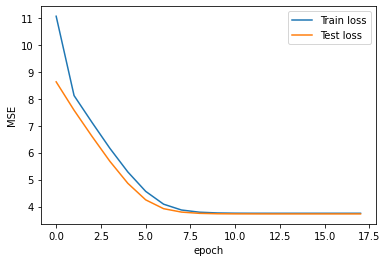

In [219]:
import matplotlib.pyplot as plt
plt.plot(result.history['loss'], label="Train loss")
plt.plot(result.history['val_loss'], label="Test loss")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [220]:
# 테스트 데이터 Prediction
user_ids = ratings_test.memberno.values[0:6]
product_ids = ratings_test.productno.values[0:6]
predictions = model.predict([user_ids, product_ids])
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

1/1 [==============================] - 0s 95ms/step
Actuals: 
        memberno  productno  rating
6787        393          8       5
26401       709         21       3
6641        888         10       4
36568       982         19       2
289         677          3       5
47416       120          3       3

Predictions: 
 [[2.7553802]
 [2.8779085]
 [2.819045 ]
 [2.8986647]
 [2.8726459]
 [2.8440218]]


In [221]:
df6 = ratings_test[0:6]
df6

,memberno,productno,rating
6787,393,8,5
26401,709,21,3
6641,888,10,4
36568,982,19,2
289,677,3,5
47416,120,3,3


In [222]:
# print(type(predictions))
df6['predictions'] = predictions
df6

C:\Users\user\anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,memberno,productno,rating,predictions
6787,393,8,5,2.755380
26401,709,21,3,2.877908
6641,888,10,4,2.819045
36568,982,19,2,2.898665
289,677,3,5,2.872646
47416,120,3,3,2.844022


In [223]:
ratings_test[0:6]

,memberno,productno,rating
6787,393,8,5
26401,709,21,3
6641,888,10,4
36568,982,19,2
289,677,3,5
47416,120,3,3


In [224]:
df6.sort_values('predictions', ascending=False, inplace=True)
df6

C:\Users\user\anaconda3\envs\ai\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,memberno,productno,rating,predictions
36568,982,19,2,2.898665
26401,709,21,3,2.877908
289,677,3,5,2.872646
47416,120,3,3,2.844022
6641,888,10,4,2.819045
6787,393,8,5,2.755380


In [225]:
# Prediction
user_ids = ratings_test.memberno.values
print(type(user_ids))
print(user_ids.shape)
product_ids = ratings_test.productno.values
predictions = model.predict([user_ids, product_ids])
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

<class 'numpy.ndarray'>
(12500,)
391/391 [==============================] - 1s 2ms/step
Actuals: 
        memberno  productno  rating
6787        393          8       5
26401       709         21       3
6641        888         10       4
36568       982         19       2
289         677          3       5
47416       120          3       3

Predictions: 
 [[2.7553802]
 [2.8779085]
 [2.819045 ]
 ...
 [2.8259213]
 [2.910737 ]
 [2.877635 ]]


In [226]:
df = ratings_test.copy()
# print(type(predictions))
df['predictions'] = predictions
df.sort_values('predictions', ascending=False, inplace=True)
df.head(10)

,memberno,productno,rating,predictions
44066,254,19,1,2.953719
10222,702,22,5,2.947778
41513,357,2,3,2.944227
3930,961,2,4,2.944074
21189,961,2,4,2.944074
41928,900,2,4,2.940846
33922,900,2,3,2.940846
17967,967,19,2,2.940602
42985,357,19,4,2.940279
36560,961,19,3,2.940126


In [227]:
df[df['memberno'] == 90].head(10)

,memberno,productno,rating,predictions
43728,90,21,2,2.863903
7333,90,25,4,2.841029
11732,90,20,4,2.832601
2131,90,1,5,2.829195
18555,90,9,4,2.815586
34250,90,9,4,2.815586
14212,90,17,4,2.800355
14587,90,15,5,2.798814
44811,90,14,4,2.794766


In [228]:
# def RMSE(y_true, y_pred):
#     return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred))) # 전부 더해져서 평균을 Scalar 형태로 변환

# 모델 로딩
model = load_model('./personalization.h5')

# 상품 로딩
i_cols = ['productno', 'name', 'cate1','cate2','cate3','cate4','cate5']
products = pd.read_csv('u.item', sep=',', names=i_cols, encoding='utf-8')
products = products.set_index('productno')
display(products.head())

# 평점 로딩
r_cols = ['memberno', 'productno', 'rating'] # 사용자 아이디, 아이템 아이디, 평점 데이터
ratings = pd.read_csv('u.data', names=r_cols,  sep=',', encoding='utf-8')
ratings = ratings[['memberno', 'productno', 'rating']].astype(int)            # timestamp 제거
display(ratings.head())

,name,cate1,cate2,cate3,cate4,cate5
productno,,,,,,
1,맛있닭 닭가슴살 소시지 훈제맛,1,0,0,0,0
2,잇메이트 저염 훈제닭가슴살,1,0,0,0,0
3,아워홈 참나무향 닭가슴살,1,0,0,0,0
4,러브잇 닭가슴살 짜장 매운맛,1,0,0,0,0
5,굽네 훈제 닭가슴살 오리지널,1,0,0,0,0


,memberno,productno,rating
0,291,13,3
1,732,18,3
2,290,24,1
3,161,25,2
4,42,19,1


In [229]:
# 아직 보지 않은 영화 리스트 함수
def get_unorder(ratings, products, memberno):
     # 특정 user_id가 평점을 매긴 모든 영화 리스트
    order_products = ratings[ratings['memberno']== memberno]['productno'].tolist()
    
    # 모든 영화명을 list 객체로 만듬. 
    total_products = products.index.tolist()
      
    # 한줄 for + if문으로 안 본 영화 리스트 생성
    unorder_products = [ product for product in total_products if product not in order_products]
    
    total_product_cnt = len(total_products) # 모든 상품수
    order_cnt = len(order_products)         # 주문한 상품수
    unorder_cnt = len(unorder_products)     # 주문하지 않은 상품수
    
    print(f"전체 상품 수: {total_product_cnt}, 평점 매긴 상품 수: {order_cnt}, 추천 대상 상품 수: {unorder_cnt}")
    
    return unorder_products

In [230]:
memberno = int(input('회원 번호를 입력하세요(3-1000):'))
unorder_products = get_unorder(ratings, products, memberno)

회원 번호를 입력하세요(3-1000):500
전체 상품 수: 25, 평점 매긴 상품 수: 44, 추천 대상 상품 수: 3


In [239]:
user_ids = np.array([memberno] * 3)
user_ids

array([500, 500, 500])

In [240]:
product_ids = np.array(unorder_products)
product_ids

array([ 4, 14, 20])

In [241]:
mu

3.5389866666666667

In [242]:
print(len(unorder_products))
user_ids = np.array([memberno] * 3)
print(type(user_ids))
print(user_ids.shape)
product_ids = np.array(unorder_products)
print(product_ids.shape)
predictions = model.predict([user_ids, product_ids])
# predictions.shape
display(predictions[:25,0])

3
<class 'numpy.ndarray'>
(3,)
(3,)
1/1 [==============================] - 0s 130ms/step


array([1.0651057, 1.0810885, 0.7387904], dtype=float32)

In [243]:
user_ids_df = pd.DataFrame(user_ids).rename(columns={0:'user_id'})
user_ids_df.head()

,user_id
0,500
1,500
2,500


In [244]:
product_ids_df = pd.DataFrame(product_ids).rename(columns={0:'productno'})
product_ids_df.head()

,productno
0,4
1,14
2,20


In [245]:
predictions_df = pd.DataFrame(predictions).rename(columns={0:'prediction'})
predictions_df.head()

,prediction
0,1.065106
1,1.081089
2,0.738790


In [246]:
df = pd.concat([user_ids_df, product_ids_df, predictions_df], axis=1)
df.head()

,user_id,productno,prediction
0,500,4,1.065106
1,500,14,1.081089
2,500,20,0.738790


In [247]:
df.sort_values(['prediction'], ascending=True, inplace=True)
df.head()

,user_id,productno,prediction
2,500,20,0.738790
0,500,4,1.065106
1,500,14,1.081089


In [248]:
df_sub = df.head(100)
df_sub

,user_id,productno,prediction
2,500,20,0.738790
0,500,4,1.065106
1,500,14,1.081089


In [249]:
product_ids = df_sub['productno']
print(product_ids)

2    20
0     4
1    14
Name: productno, dtype: int32


In [250]:
df_sub['prediction']
print(type(df_sub['prediction']))
print(df_sub['prediction'])

<class 'pandas.core.series.Series'>
2    0.738790
0    1.065106
1    1.081089
Name: prediction, dtype: float32


In [251]:
recom_df = products.loc[df_sub['productno']]
recom_df.head()

,name,cate1,cate2,cate3,cate4,cate5
productno,,,,,,
20,유산균슬림다이어트,0,0,0,1,0
4,러브잇 닭가슴살 짜장 매운맛,1,0,0,0,0
14,수비드닭가슴살빅샐러드,0,0,1,0,0


In [252]:
recom_df['prediction'] = np.array(df_sub['prediction'])
recom_df

,name,cate1,cate2,cate3,cate4,cate5,prediction
productno,,,,,,,
20,유산균슬림다이어트,0,0,0,1,0,0.738790
4,러브잇 닭가슴살 짜장 매운맛,1,0,0,0,0,1.065106
14,수비드닭가슴살빅샐러드,0,0,1,0,0,1.081089


In [253]:
# 영화 추천
def recomm_product(model, memberno, unorder_products, top_n=10):
    user_ids = np.array([memberno] * len(unorder_products)) # 시청하지 않은 영화수만큼 회원번호 복제
    product_ids = np.array(unorder_products) # 시청하지 않은 영화 번호 numpy 배열로 변경
    predictions = model.predict([user_ids, product_ids]) # 모델 사용하여 평점 예측
    # display(predictions[:5,0]) # 5건 출력
    
    user_ids_df = pd.DataFrame(user_ids).rename(columns={0:'memberno'})          # user_id
    product_ids_df = pd.DataFrame(product_ids).rename(columns={0:'productno'})       # movid_id
    predictions_df = pd.DataFrame(predictions).rename(columns={0:'prediction'}) # 점수 예측
    df = pd.concat([user_ids_df, product_ids_df, predictions_df], axis=1)         # DataFrame 병합
    df.sort_values(['prediction'], ascending=False, inplace=True)               # 평점 내림차순 정렬
    
    df_sub = df.head(top_n)   # 추천수 만큼 분할
    recom_df = products.loc[df_sub['productno']] # productno에 해당하는 상품정보 산출
    recom_df['prediction'] = np.array(df_sub['prediction']) # 평점을 추천 Dataframe에 컬럼 추가
    
    return recom_df[['name', 'prediction']]

In [254]:
model = load_model('./personalization.h5')
user_id = int(input('회원 번호를 입력하세요(3-500):')) # 123
unorder_products = get_unorder(ratings, products, memberno)
df = recomm_product(model, memberno, unorder_products, 10)
display(df)

회원 번호를 입력하세요(3-500):500
전체 상품 수: 25, 평점 매긴 상품 수: 44, 추천 대상 상품 수: 3
1/1 [==============================] - 0s 126ms/step


,name,prediction
productno,,
14,수비드닭가슴살빅샐러드,1.081089
4,러브잇 닭가슴살 짜장 매운맛,1.065106
20,유산균슬림다이어트,0.738790
